# Figure 5: Arctic Surface Feedbacks

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load feedback specific functions

In [2]:
from feedback_functions import *

### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

### Arctic-normalized Feedbacks

### Calculate the Arctic-average temperature increase.

In [5]:
os.listdir('feedbacks_soden/mod_by_me/output_jonahks/')

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'cm2000_def_slfout_cosp_1',
 'zonal_20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1_APRP.nc',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 '20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1_APRP.nc',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_Fvars_check',
 'cm2000_nifix2_slfout_cosp_1',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

In [6]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

ts_dict = {}
for i in path_dict:
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
    ts_dict[i] = calc_arc_dT(ts_i,ts_f)
    
print(ts_dict)

{'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.89348545), 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
array(5.06160638), 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
array(4.97446844), 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.86478516), 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
array(4.8824035), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(5.11944737), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
array(5.29178813)}


In [7]:
def get_APRP(case_path):
    fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'
    _fbs = os.listdir("%s/%s" % (fb_dir,case_path)) # List feedback files
    _aprp_file = [i for i in _fbs if "APRPsw_feedback" in i][0]
    _aprp = add_weights(xr.open_dataset("%s/%s/%s" % (fb_dir,case_path,_aprp_file)))
        
    return _aprp

In [8]:
cases2 = os.listdir(fb_dir)
case_dict2 = {} # Cases are keys, feedback dictionaries are values
case_dict2_aprp = {} # Cases are keys, feedback dictionaries are values


for _case in cases2:
    if "SFCnonorm" in _case:
        print(_case)
        case_dict2[_case] = org_feedbacks_case(_case)
        case_dict2_aprp[_case] = get_APRP(_case)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1


In [9]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

In [10]:
desired_order_list = ['CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100'
                      ]

case_dict2b = {k: case_dict2[k] for k in desired_order_list}
case_dict2b_aprp = {k: case_dict2_aprp[k] for k in desired_order_list}

In [28]:
out2 = weight_feedbacks(case_dict2b,weights=ts_dict,labels=label_dict,lat_range=[66,90])

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [29]:
# Create Arctic-normalized APRP SW cloud fb variable
APRP_SW_FB = []

for i in case_dict2b_aprp:
    dTS_arc = ts_dict[i]
    _case = case_dict2b_aprp[i]
    
    _case['SWfeedback_cloud_AN'] = _case['SWfeedback_cloud_f'] / dTS_arc
    _ds = _case['SWfeedback_cloud_AN']
    
    weights = _case['cell_weight']
    mask = np.bitwise_or(_ds['lat']<=66,_ds['lat']>82)
    
    _arc_val = masked_average(_ds,dim=['lat','lon'],weights=weights,mask=mask)
    APRP_SW_FB.append(_arc_val)
    
out2['APRP_SWfb'] = APRP_SW_FB

## Trying a simple linear regression against the LW feedback

Get GOCCP value to calculate bias

In [30]:
_goccp_metric = SatComp_Metric(casedir=case_dir)

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.


In [31]:
goccp_data = _goccp_metric.goccp_data

cldtot_monthly = add_weights(goccp_data['CLDTOT_CAL'].groupby('time.month').mean('time'))

# cldtot_monthly
mask = cldtot_monthly['lat'] < 66
arc_mean = masked_average(cldtot_monthly,mask=mask,weights=cldtot_monthly['cell_weight'],dim=['lat','lon'])

Get variables

__LW Feedback Parameter__

__Winter Cloud from the Models__

In [32]:
init_dir = 'satcomp/'
pert_dir = 'satcomp_+4K/'

In [33]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

In [34]:
winter_totcloud_init = {}
winter_lowcloud_init = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    
    _initall = xr.open_dataset(_init_path)
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01'))#.groupby('time.season').mean('time')
    winter_totcloud_init[i] = _temp_dat
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01'))#.groupby('time.season').mean('time')
    winter_lowcloud_init[i] = _temp_dat
    
    _initall.close()

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [35]:
winter_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _mean = _ds.groupby('time.season').mean('time').sel(season='DJF')
    mask = _ds['lat'] < 66
    _winter_avg = masked_average(_mean,dim=['lat','lon'],weights=_mean['cell_weight'],mask=mask)
    winter_totcloud_dict[i] = _winter_avg
    
winter_totcloud = np.array(list(winter_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

In [36]:
apr_totcloud_dict = {}
fma_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _apr_mean = _ds.groupby('time.month').mean('time').sel(month=3)
    _fma_mean = _ds.groupby('time.month').mean('time').sel(month=[1,2,3]).mean('month')
    mask = _ds['lat'] < 66
    _apr_avg = masked_average(_apr_mean,dim=['lat','lon'],weights=_apr_mean['cell_weight'],mask=mask)
    _fma_avg = masked_average(_fma_mean,dim=['lat','lon'],weights=_fma_mean['cell_weight'],mask=mask)
    apr_totcloud_dict[i] = _apr_avg
    fma_totcloud_dict[i] = _fma_avg
    
apr_totcloud = np.array(list(apr_totcloud_dict.values())).flatten()
fma_totcloud = np.array(list(fma_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

## Calculate low cloud cover change

In [37]:
init_dir = 'satcomp/'
pert_dir = 'satcomp_+4K/'

In [38]:
os.listdir(pert_dir)

['20201231_4Ksst_cesm2satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam6satcomp_wbf_1_inp_1',
 'sst_HadOIBl+4K_bc_1.9x2.5_2000climo_c180511.nc',
 '20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100',
 '20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1',
 '20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10',
 '20200817_4Ksst_cam61satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05',
 'sst_HadOIBl_bc_1.9x2.5_2000climo_c180511.nc',
 '20200830_152800_FLDSC4K_wbf_1_inp_1']

In [39]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

In [40]:
low_cloud_init = {}
low_cloud_pert = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    _pert_path = '%s%s/%s.nc' % (pert_dir,_pair[1],_pair[1])
    
    _initall = xr.open_dataset(_init_path)
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
#     _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2010-02-01','2013-01-01')).groupby('time.month').mean('time')
    low_cloud_init[i] = _temp_dat
    _initall.close()
    
    _pertall = xr.open_dataset(_pert_path)
    _pertall['time'] = _pertall['time_bnds'].isel(bnds=0)
    _temp_dat = _pertall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    low_cloud_pert[i] = _temp_dat
    _pertall.close()


CAM6_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_100


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [41]:
low_cloud_diff = {}

for i in low_cloud_init:
    diff = low_cloud_pert[i] - low_cloud_init[i]
    
    low_cloud_diff[i] = diff

In [42]:
first_ds = next(iter(low_cloud_diff.values()))
weight_ds = add_weights(first_ds)

wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[first_ds['month']], name='month_length')

all_weights = month_length @ weight_ds['cell_weight']

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [43]:
dC_dict = {}
dC_dict_apr = {}
for i in low_cloud_diff:
    _ds = low_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    _final_diff2 = masked_average(_ds,dim=['lat','lon'],weights=all_weights,mask=mask)
    dC_dict[i] = _final_diff    
    dC_dict_apr[i] = _final_diff2.sel(month=1)

## Plot the stuff

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


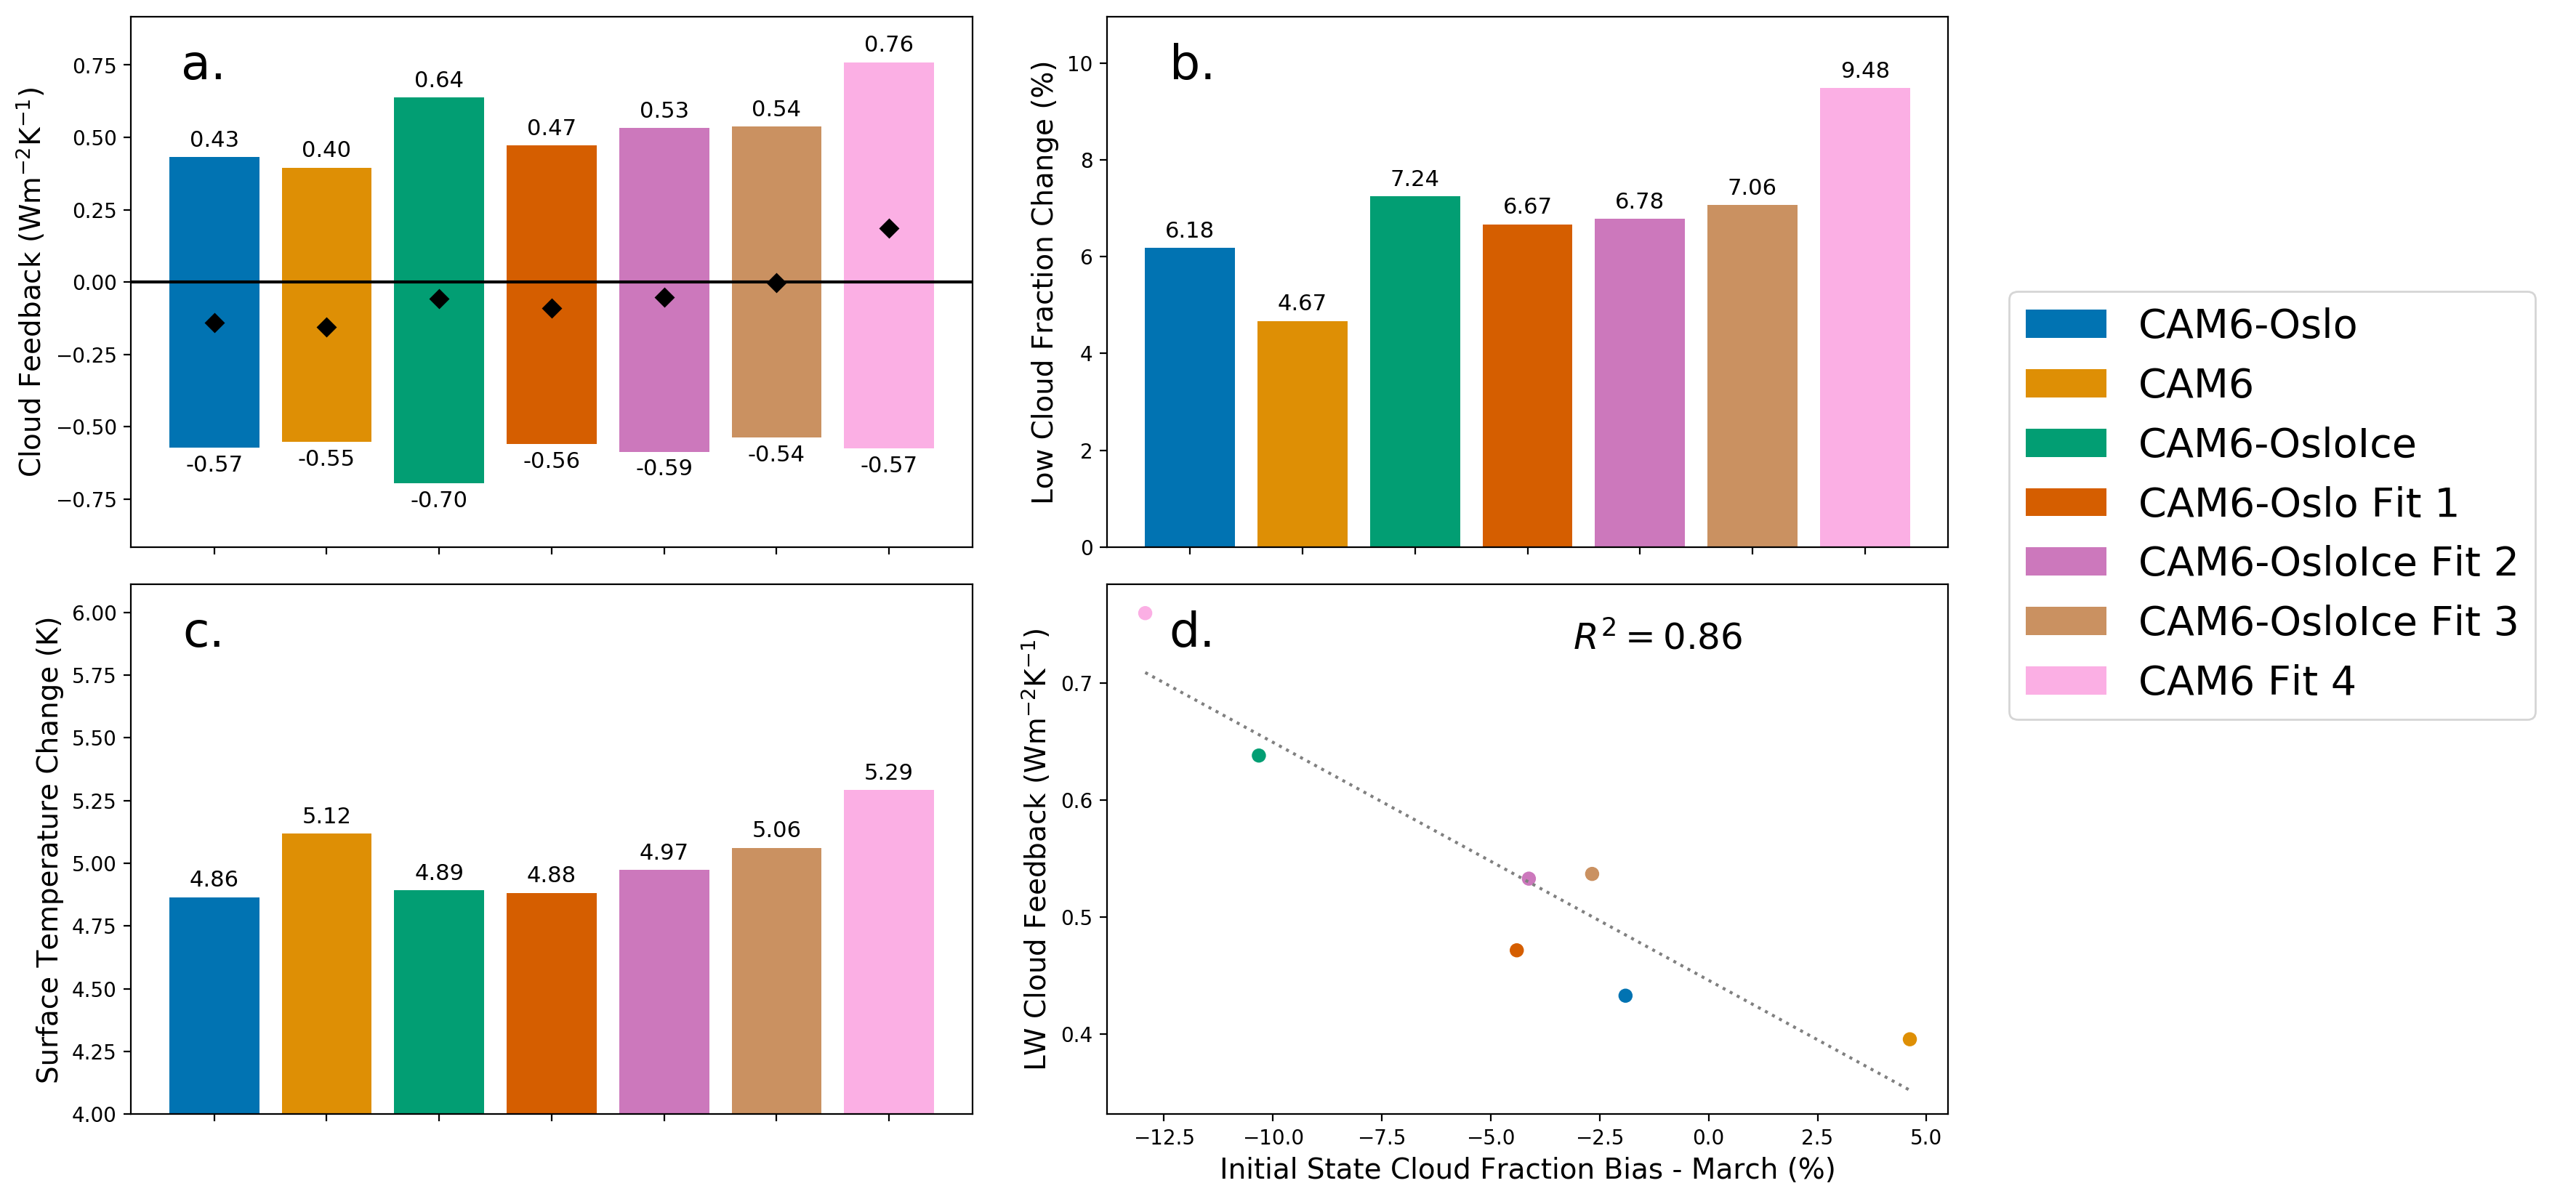

In [44]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

net_vals = {}
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# autolabel4(out_test[0],axs[0])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[1])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=ts_dict,ax=axs[2])

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=3))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs[3].scatter(x, y, c=colormap[categories],marker='o')
axs[3].plot(x_new,y_new,c='grey',linestyle='dotted')

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Low Cloud Fraction Change (%)',fontsize=14)

axs[2].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[2].set_ylim((4,axs[2].get_ylim()[1]))


axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Initial State Cloud Fraction Bias - March (%)',fontsize=14)

fig.text(0.65, 0.44, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

In [53]:
to_png(fig,'feedbacks_march')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


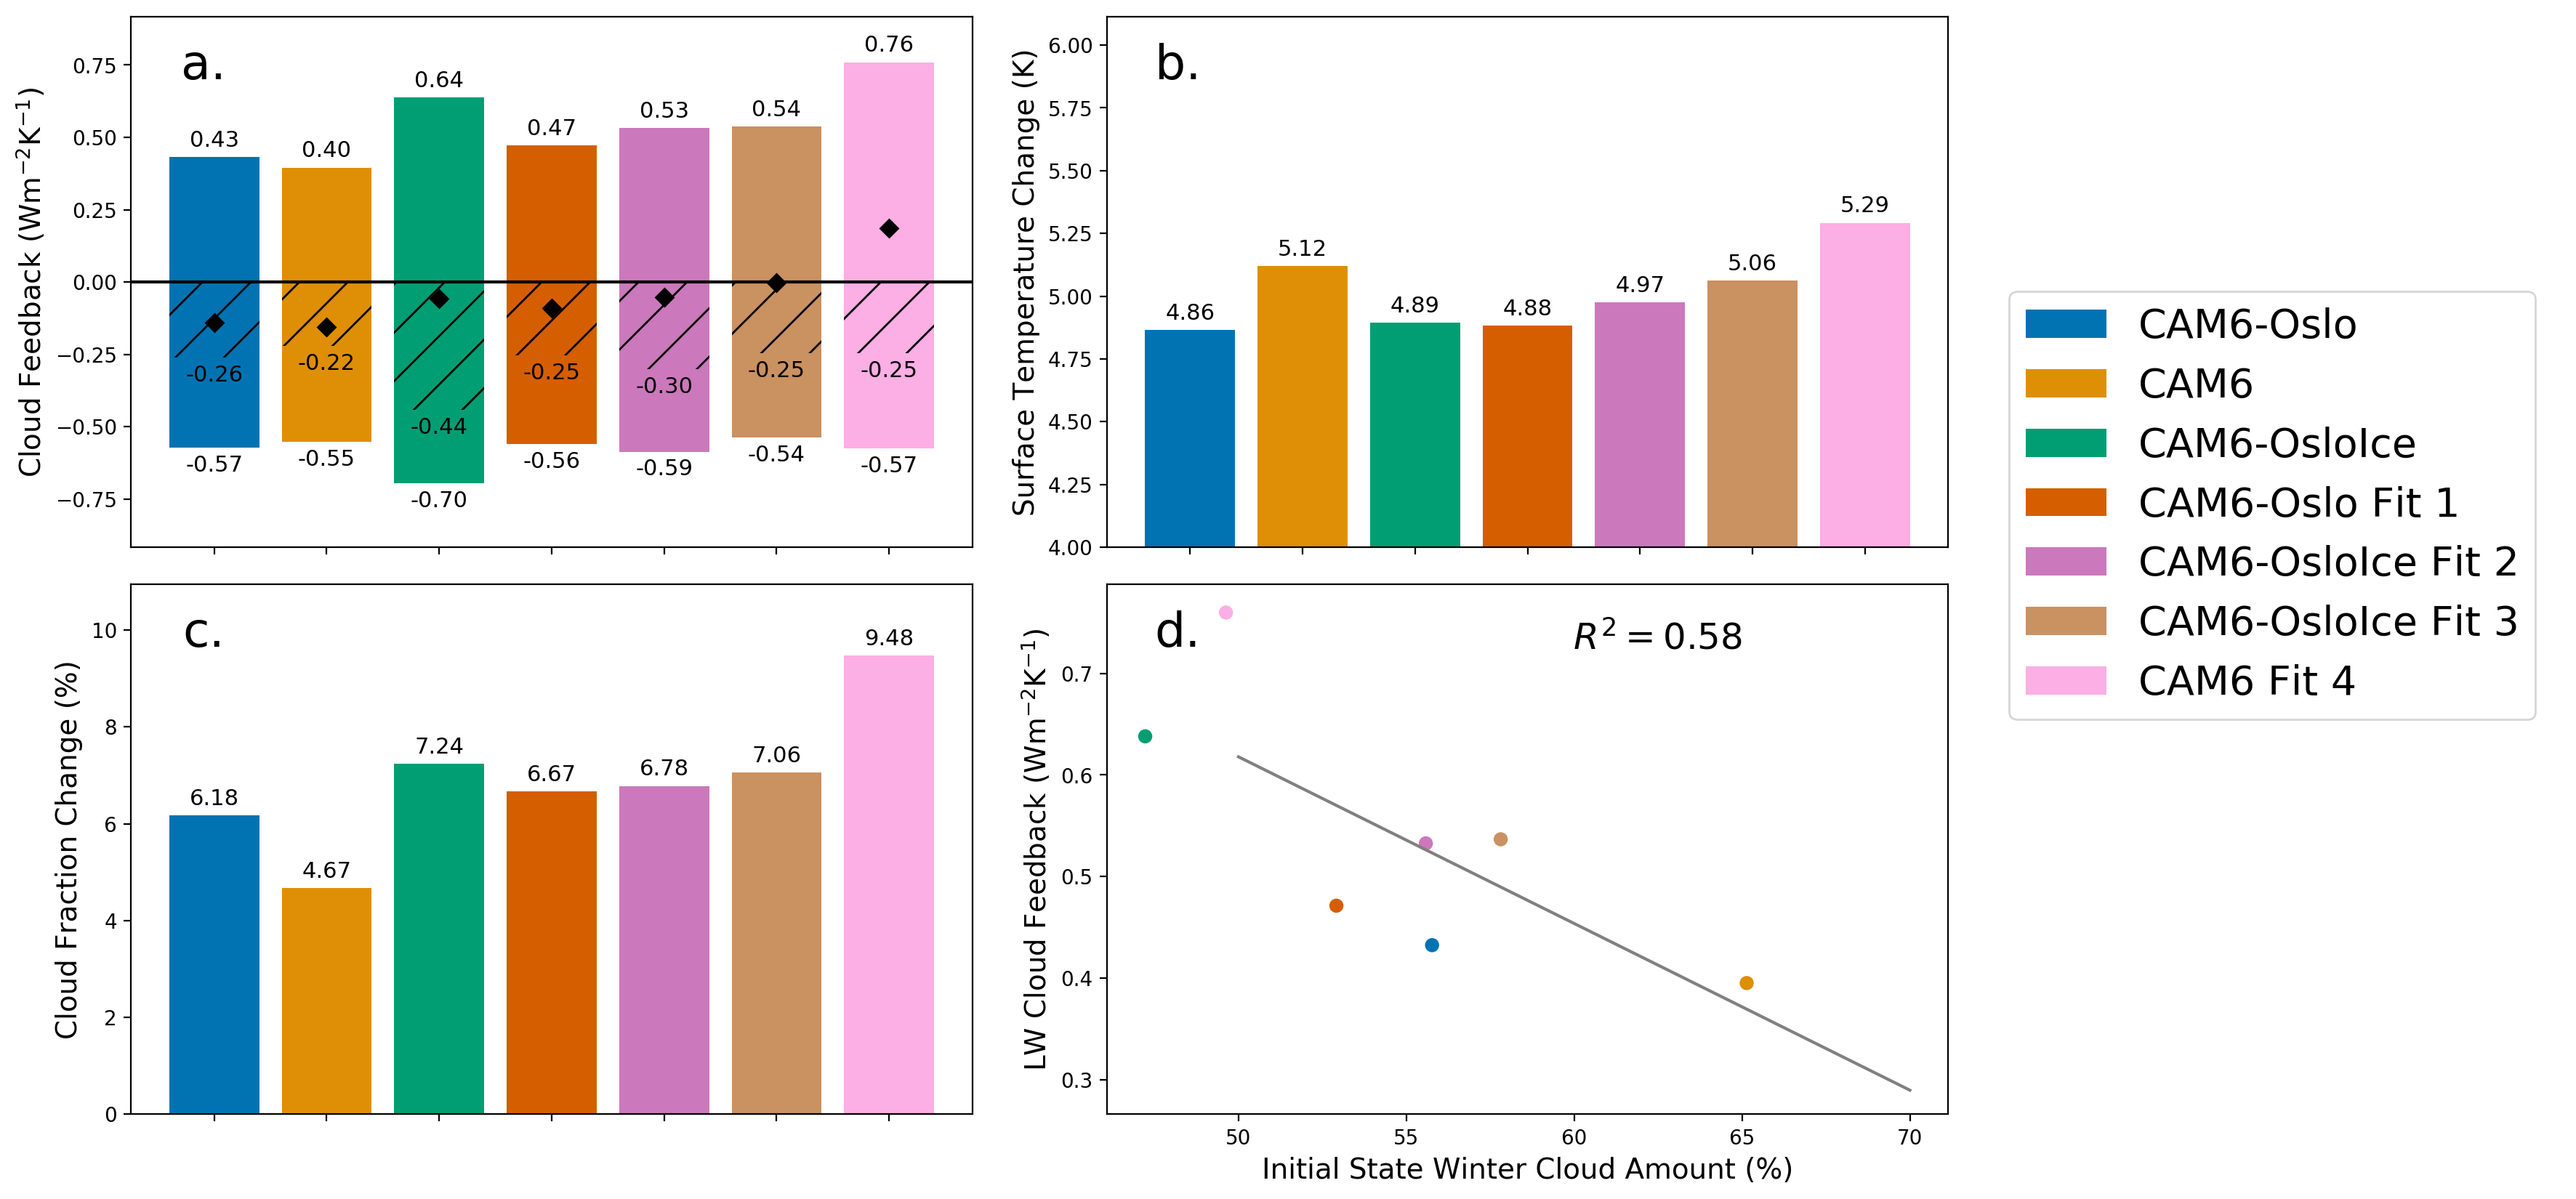

In [49]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt2,SWfb_axes2,vals3 = barplot_single(case_dict2b,out2,'APRP_SWfb',
                                    labels=label_dict,ax=axs[0],hatch = '/')

net_vals = {}
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# out_test2 = axs[0].plot(np.arange(0,7),out2['APRP_SWfb'],marker='D',color='red',linestyle="")


# autolabel4(out_test[0],axs[0])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=ts_dict,ax=axs[1])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[2])

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(winter_totcloud)
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
x_new = np.linspace(50, 70, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs[3].scatter(x, y, c=colormap[categories])
axs[3].plot(x_new, y_new,c='grey')#,linestyle='dashed')

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[1].set_ylim((4,axs[1].get_ylim()[1]))

axs[2].set_ylabel('Cloud Fraction Change (%)',fontsize=14)

axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Initial State Winter Cloud Amount (%)',fontsize=14)

fig.text(0.65, 0.44, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.485, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.485, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


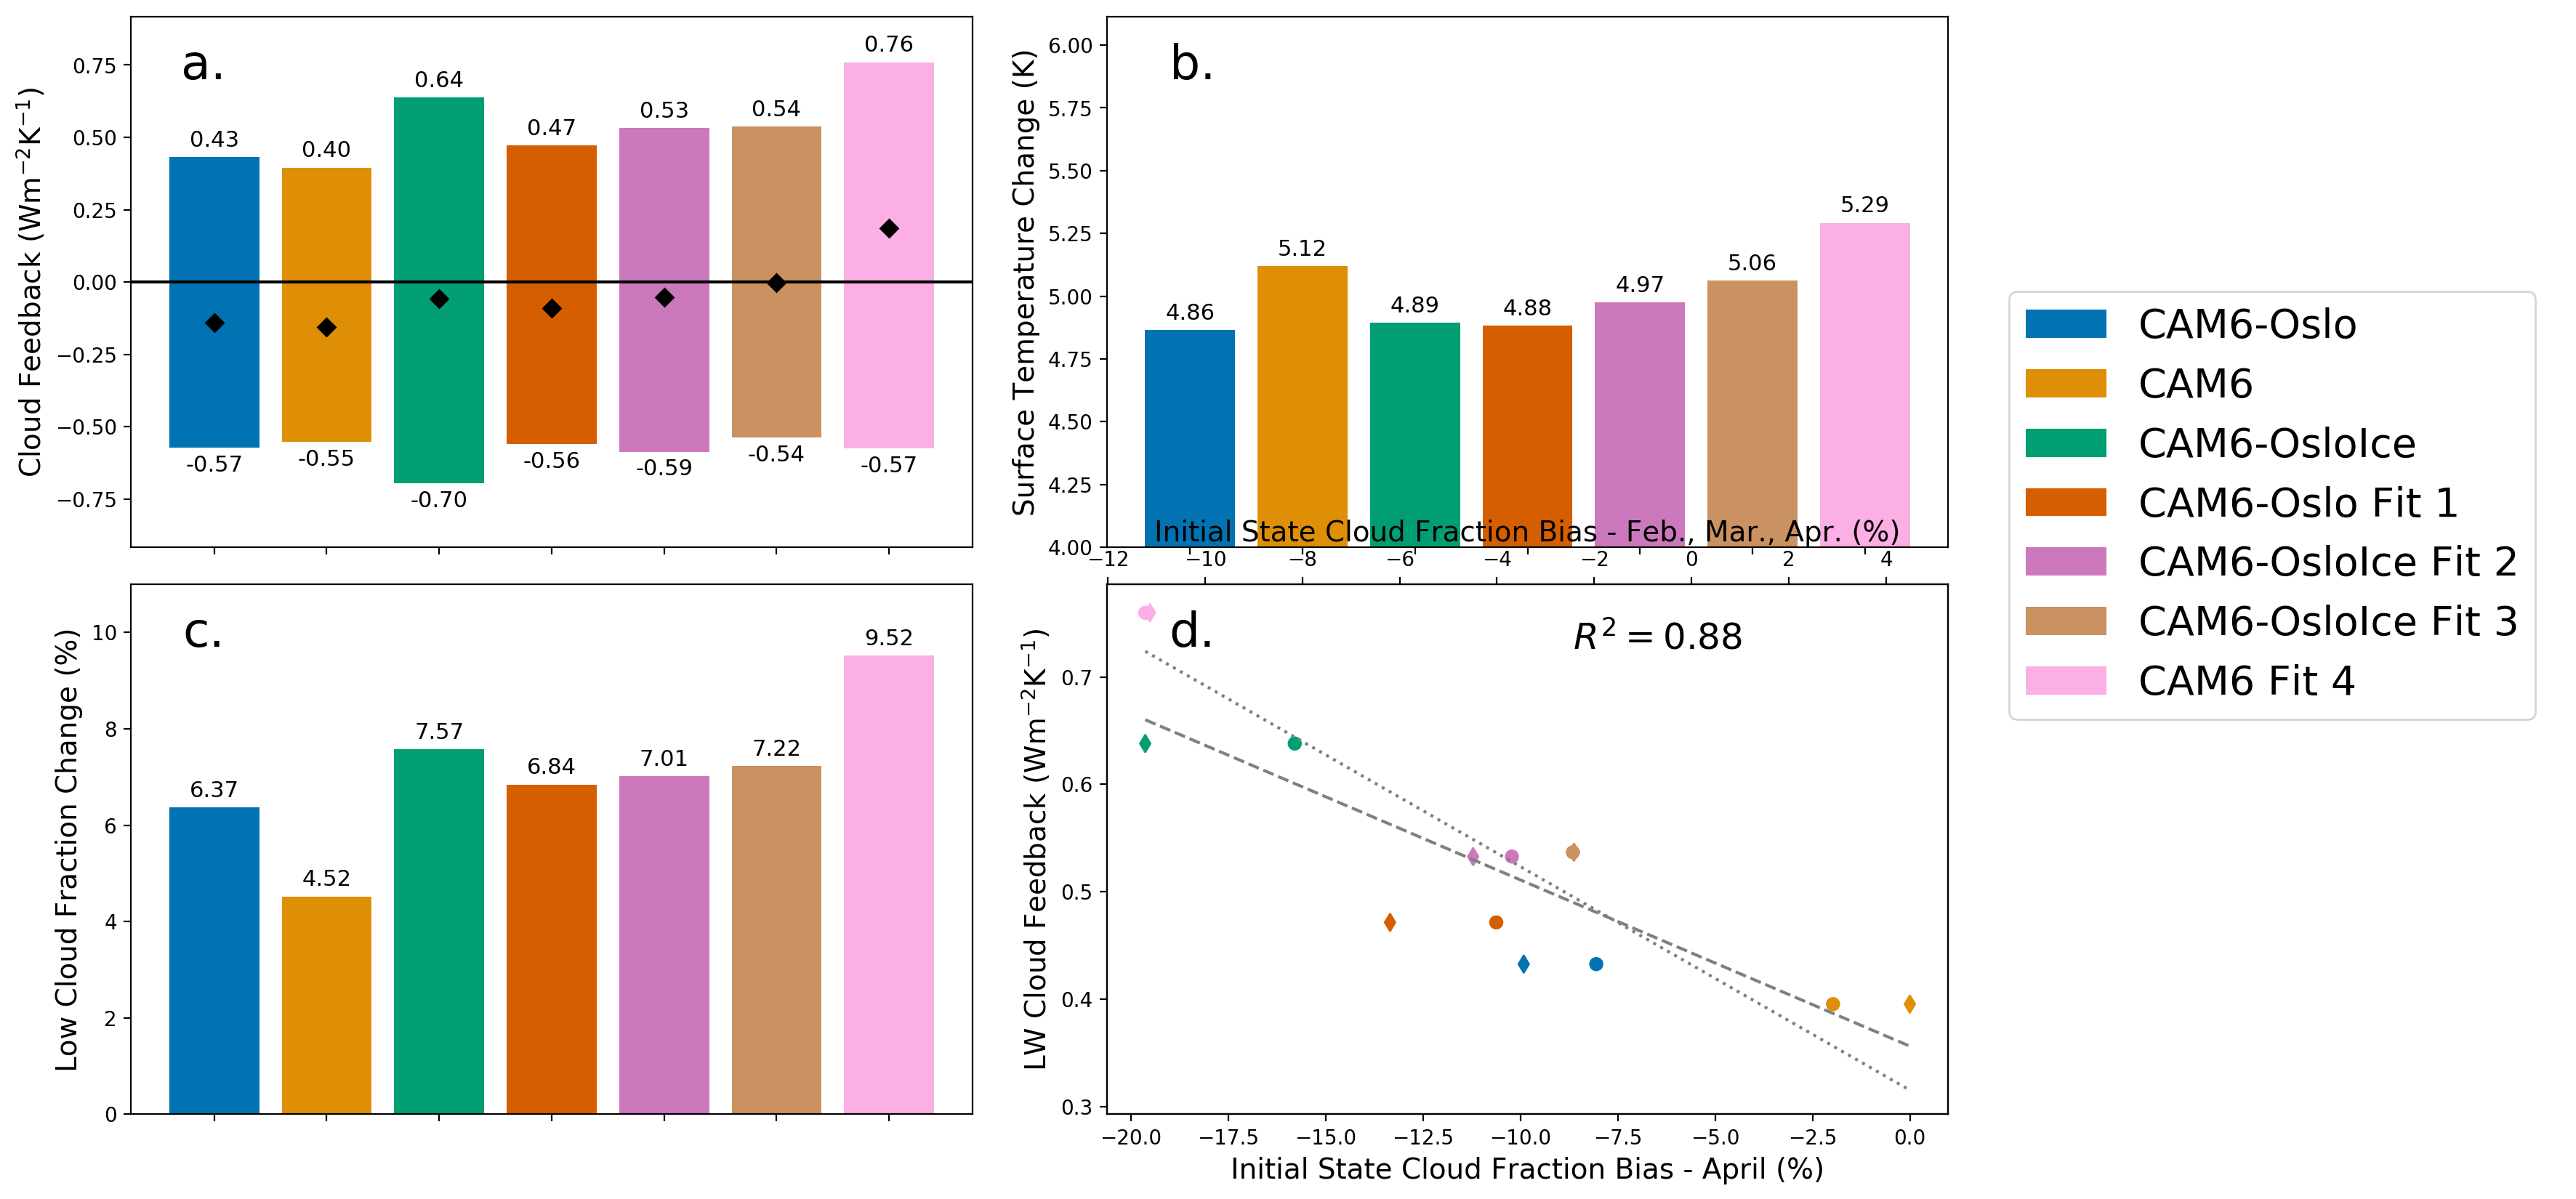

In [54]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

net_vals = {}
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# autolabel4(out_test[0],axs[0])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=ts_dict,ax=axs[1])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[2])

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs[3].scatter(x, y, c=colormap[categories],marker='o')
axs[3].plot(x_new,y_new,c='grey',linestyle='dotted')

x2 = np.array(fma_totcloud) - float(arc_mean.sel(month=[2,3,4]).mean('month'))
model2 = LinearRegression()
model2.fit(x2.reshape(-1,1), y.reshape(-1,1))
x_new2 = np.linspace(min(x2), max(x2), 100)
y_new2 = model2.predict(x_new2[:, np.newaxis])
y_pred2 = model2.predict(x2.reshape(-1,1))

axs3b = axs[3].twiny()
axs3b.scatter(x2, y, c=colormap[categories],marker='d')
axs3b.plot(x_new2,y_new2,c='grey',linestyle='dashed')
axs3b.set_xlabel('Initial State Cloud Fraction Bias - Feb., Mar., Apr. (%)',fontsize=14)

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[1].set_ylim((4,axs[1].get_ylim()[1]))

axs[2].set_ylabel('Low Cloud Fraction Change (%)',fontsize=14)

axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.44, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

In [62]:
to_png(fig,"feedbacks_aprcorrelation_lowcloud")

## Trying a simple linear regression against the LW feedback

Get GOCCP value to calculate bias

In [58]:
_goccp_metric = SatComp_Metric(casedir=case_dir)

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.


In [28]:
goccp_data = _goccp_metric.goccp_data

cldtot_monthly = add_weights(goccp_data['CLDTOT_CAL'].groupby('time.month').mean('time'))

# cldtot_monthly
mask = cldtot_monthly['lat'] < 66
arc_mean = masked_average(cldtot_monthly,mask=mask,weights=cldtot_monthly['cell_weight'],dim=['lat','lon'])

Get variables

__LW Feedback Parameter__

__Winter Cloud from the Models__

In [21]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

In [22]:
winter_totcloud_init = {}
winter_lowcloud_init = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    
    _initall = xr.open_dataset(_init_path)
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01'))
#     _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
    winter_totcloud_init[i] = _temp_dat
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
    winter_lowcloud_init[i] = _temp_dat
    
    _initall.close()

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [23]:
winter_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _mean = _ds.groupby('time.season').mean('time').sel(season='DJF')
    mask = _ds['lat'] < 66
    _winter_avg = masked_average(_mean,dim=['lat','lon'],weights=_mean['cell_weight'],mask=mask)
    winter_totcloud_dict[i] = _winter_avg
    
winter_totcloud = np.array(list(winter_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

In [24]:
apr_totcloud_dict = {}
fma_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _apr_mean = _ds.groupby('time.month').mean('time').sel(month=3)
    _fma_mean = _ds.groupby('time.month').mean('time').sel(month=[1,2,3]).mean('month')
    mask = _ds['lat'] < 66
    _apr_avg = masked_average(_apr_mean,dim=['lat','lon'],weights=_apr_mean['cell_weight'],mask=mask)
    _fma_avg = masked_average(_fma_mean,dim=['lat','lon'],weights=_fma_mean['cell_weight'],mask=mask)
    apr_totcloud_dict[i] = _apr_avg
    fma_totcloud_dict[i] = _fma_avg
    
apr_totcloud = np.array(list(apr_totcloud_dict.values())).flatten()
fma_totcloud = np.array(list(fma_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

## Old

(<Figure size 576x432 with 1 Axes>,
 {'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.43259314),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.39532478),
  'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.63801877),
  'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
  array(0.47142087),
  'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
  array(0.53272564),
  'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
  array(0.53675754),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
  array(0.759838)})

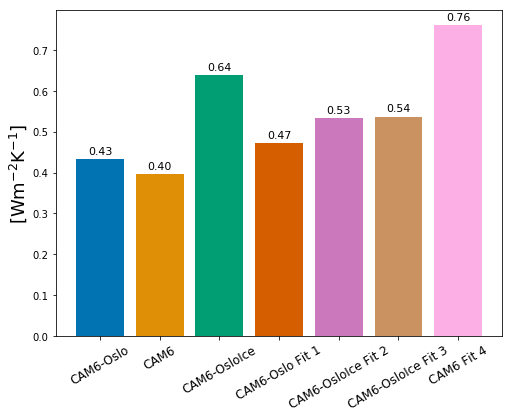

In [11]:
barplot_single(case_dict2b,out2,'cloudlw_fb',labels=label_dict)

(<Figure size 576x432 with 1 Axes>,
 {'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.57317116),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.55160191),
  'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.69509165),
  'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
  array(-0.56070876),
  'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
  array(-0.58598874),
  'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
  array(-0.5379586),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
  array(-0.57440502)})

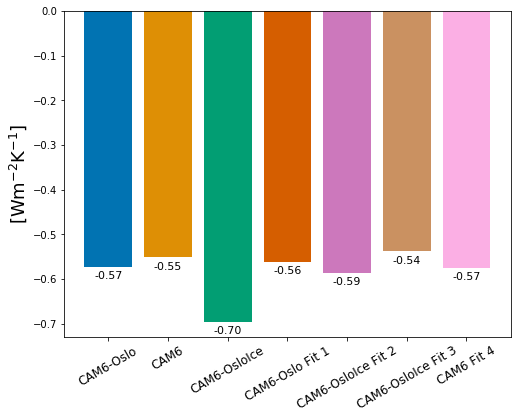

In [12]:
barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict)

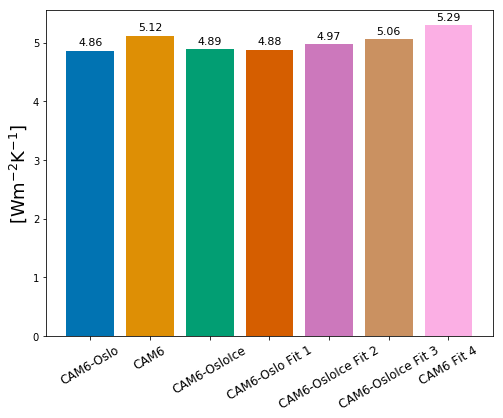

In [13]:
dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict,vals=ts_dict)

In [14]:
dT_axes.set_ylabel('Surface Temperature Change (K)', fontsize=14)

Text(28.8313,0.5,'Surface Temperature Change (K)')

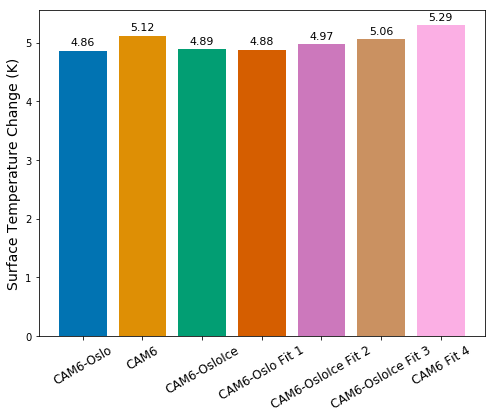

In [15]:
dT_plt

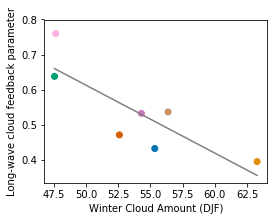

Mean squared error: 0.00
Coefficient of determination: 0.70


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = np.array(out2['cloudlw_fb'])

x = np.array(fma_totcloud)

# create a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))

# predict y from the data
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))

categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])

colormap = np.array(sns.color_palette('colorblind'))

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x, y, c=colormap[categories])
ax.plot(x_new, y_new,c='grey')#,linestyle='dashed')

ax.set_xlabel('Winter Cloud Amount (DJF)')
ax.set_ylabel('Long-wave cloud feedback parameter')

ax.axis('tight')

plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

In [131]:
x

array([55.93317586, 62.01106323, 48.19300804, 53.36631319, 53.76850932,
       55.33274764, 44.35545869])

In [130]:
x - float(arc_mean.sel(month=4))

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([ -8.05194528,  -1.97405791, -15.7921131 , -10.61880795,
       -10.21661182,  -8.6523735 , -19.62966245])

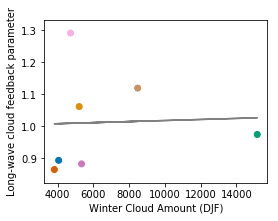

Mean squared error: 0.02
Coefficient of determination: 0.00


In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = np.array(out2['cloudlw_fb'])
y = np.array(list(ts_dict.values())).flatten() -4

ice_size = np.array([149,166,132,162,124,112,212])
ice_conc = np.array([4060,5210,15170,3820,5340,8480,4730])
       
x = ice_conc
# x = np.array(list(dC_dict.values())).flatten()

# create a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))

# predict y from the data
x_new = np.linspace(0.35, 0.85, 100)
x_new = np.linspace(4, 10, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))

categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])

colormap = np.array(sns.color_palette('colorblind'))

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x, y, c=colormap[categories])
# ax.plot(x_new, y_new,c='grey')#,linestyle='dashed')
ax.plot(x, y_pred,c='grey')#,linestyle='dashed')

ax.set_xlabel('Winter Cloud Amount (DJF)')
ax.set_ylabel('Long-wave cloud feedback parameter')

ax.axis('tight')

plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

In [ ]:
np.array(list(dC_dict.values())).flatten()